In [132]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mc

#from statannotations.Annotator import Annotator
import allen_utils as allen


In [133]:
FIGURE_PATH = r'M:\analysis\Myriam_Hamon\results\roc_analysis'

In [134]:
info_path = os.path.join(r'\\sv-nas1.rcp.epfl.ch', 'Petersen-Lab', 'z_LSENS', 'Share', f'Axel_Bisi_Share',
                                 'dataset_info')
mouse_info_df = pd.read_excel(os.path.join(info_path, 'joint_mouse_reference_weight.xlsx')) # load mouse info file

data_path = os.path.join('\\\\sv-nas1.rcp.epfl.ch', 'Petersen-Lab', 'analysis', 'Myriam_Hamon', 'results')
data_path_combined = os.path.join('\\\\sv-nas1.rcp.epfl.ch', 'Petersen-Lab', 'analysis', 'Myriam_Hamon', 'combined_results')
roc_results_files = glob.glob(os.path.join(data_path, '**', '*_roc_results.csv'), recursive=True) # find all roc results files
roc_results_files = roc_results_files + glob.glob(os.path.join(data_path_combined, '**', '*_roc_results.csv'), recursive=True)

In [135]:
indx_learning = np.array(['whisker_0' in file for file in roc_results_files])
indx_expert = ~indx_learning
learning_day_files = np.array(roc_results_files)[indx_learning]
expert_day_files = np.array(roc_results_files)[indx_expert]


In [136]:
roc_df_learning = pd.concat([pd.read_csv(f) for f in learning_day_files], ignore_index=True) # concatenate all roc results files
roc_df_learning['day'] = 'learning'

roc_df_expert = pd.concat([pd.read_csv(f) for f in expert_day_files], ignore_index=True) # concatenate all roc results files
roc_df_expert['day'] = 'expert'
roc_df = pd.concat([roc_df_learning, roc_df_expert], ignore_index=True)
# Use the reward group column of mouse_info_df to add the reward group to roc_df
mouse_info_df = mouse_info_df.rename(columns={'mouse_name': 'mouse_id'})

roc_df = roc_df.merge(mouse_info_df[['mouse_id', 'reward_group']], on='mouse_id', how='left')
print('Present mice:', roc_df['mouse_id'].unique(), 'Number of mice', roc_df['mouse_id'].nunique(), 'per reward group',  roc_df.groupby('reward_group')['mouse_id'].nunique(), 'Per recording day', roc_df.groupby('day')['mouse_id'].nunique())
print(roc_df['analysis_type'].unique())

excluded_mice = ['AB077','AB082']
roc_df = roc_df[~roc_df['mouse_id'].isin(excluded_mice)]

Present mice: ['AB130' 'MH030' 'MH034' 'AB134' 'AB133' 'MH035' 'AB087' 'MH008' 'MH009'
 'AB119' 'AB124' 'AB131' 'MH029' 'AB094' 'MH007' 'AB149' 'AB093' 'MH013'
 'AB136' 'AB141' 'AB077' 'AB125' 'AB128' 'AB127' 'MH026' 'MH004' 'AB086'
 'AB162' 'MH010' 'AB154' 'AB116' 'AB126' 'AB153' 'MH025' 'MH017' 'AB121'
 'AB145' 'AB120' 'AB107' 'MH039' 'AB147' 'AB122' 'MH015' 'MH028' 'AB102'
 'AB156' 'AB139' 'AB095' 'MH037' 'AB159' 'MH020' 'MH011' 'AB150' 'AB082'
 'AB151' 'AB143' 'MH021' 'AB117' 'AB085' 'AB123' 'AB129' 'AB140' 'AB092'
 'MH023' 'AB138' 'MH036' 'MH027' 'MH038' 'MH032' 'AB080' 'MH031' 'MH022'
 'AB164' 'AB132' 'MH014' 'AB163' 'AB142' 'MH018' 'AB104' 'MH001' 'MH019'] Number of mice 81 per reward group reward_group
R+    48
R-    33
Name: mouse_id, dtype: int64 Per recording day day
expert      18
learning    79
Name: mouse_id, dtype: int64
['whisker_passive_pre' 'whisker_passive_post' 'whisker_active'
 'whisker_pre_vs_post_learning' 'auditory_passive_pre'
 'auditory_passive_post' 'auditory

In [137]:
#roc_df = create_area_custom_column(roc_df)
roc_df = allen.create_area_custom_column(roc_df)

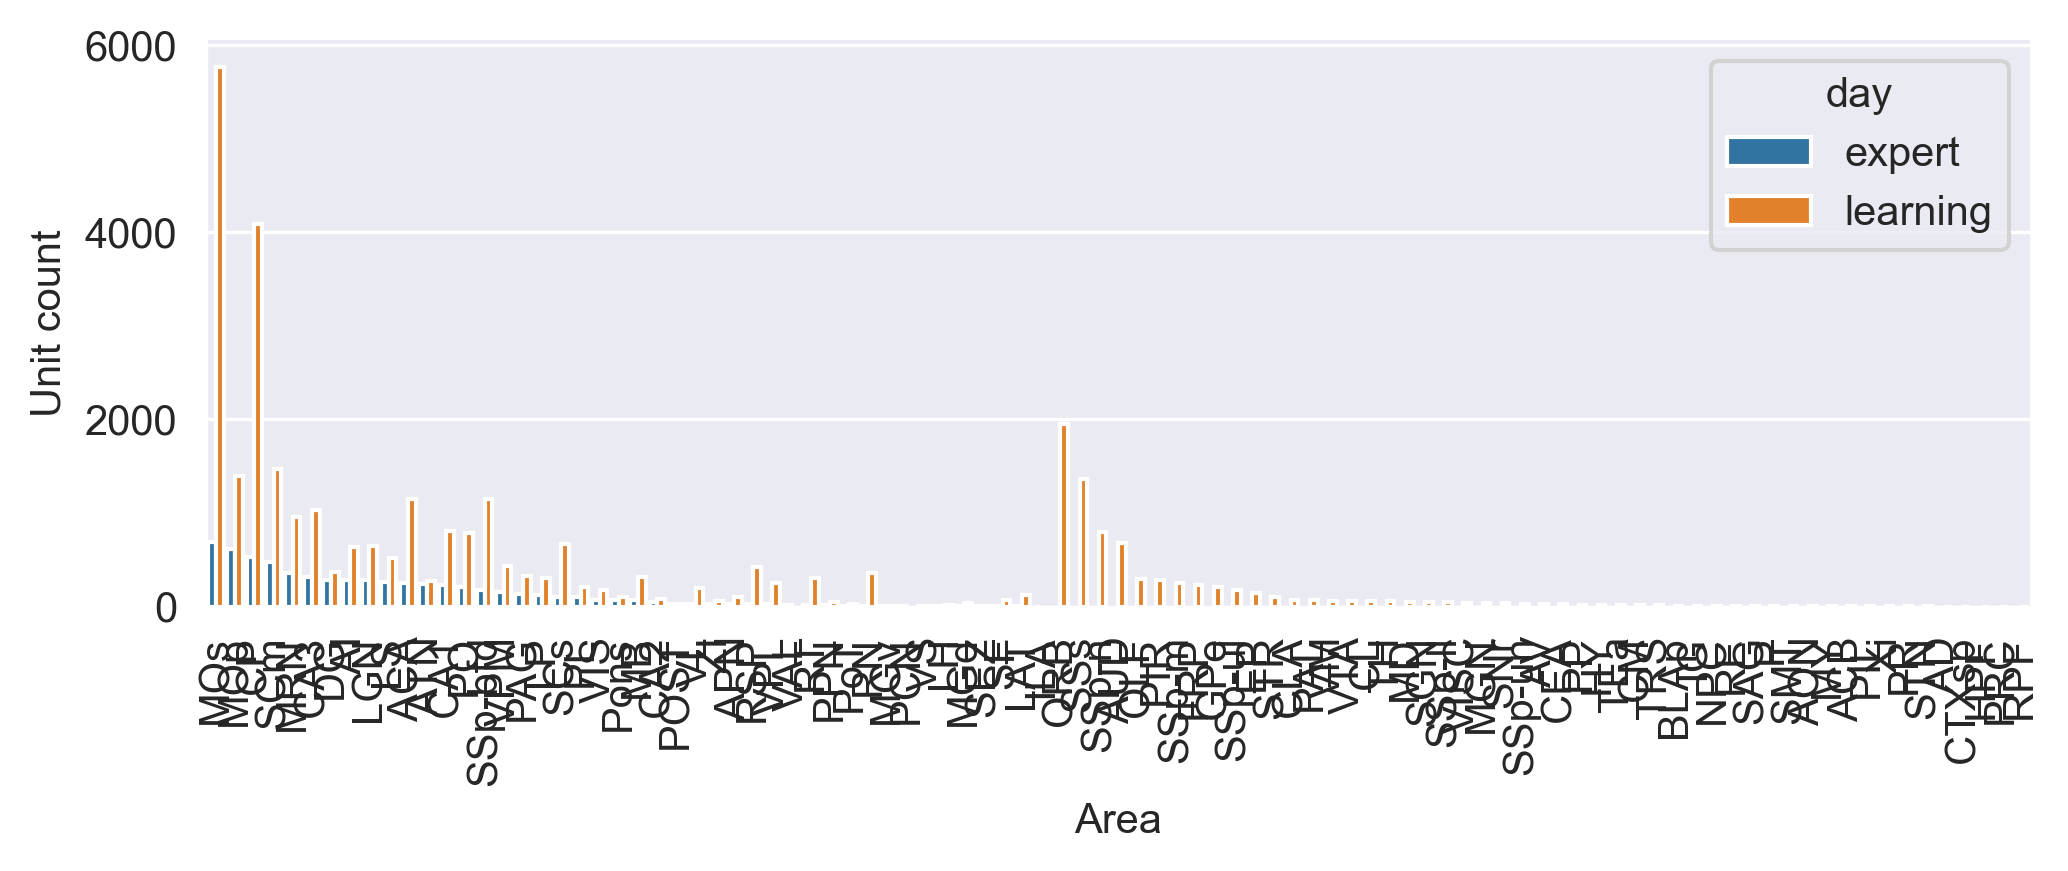

In [138]:
df_counts = roc_df.groupby(['analysis_type','day'])['area_acronym_custom'].value_counts().reset_index()
df_counts = df_counts[df_counts.analysis_type=='whisker_passive_pre']
fig, ax = plt.subplots(1,1,figsize=(7,3),dpi=300)
sns.barplot(data=df_counts,
            ax=ax,
            x='area_acronym_custom',
            y='count',
            hue ='day')
sns.despine()
# ax.set_xticks(labels=df_counts['area_acronym_custom'], ticks=ax.get_xticks(), rotation=90)
ax.tick_params(axis='x', rotation=90)

ax.set_ylabel('Unit count')
ax.set_xlabel('Area')
fig.tight_layout()
fname = 'roc_neuron_count_passivemice.png'
#fig.savefig(os.path.join(FIGURE_PATH, fname), bbox_inches='tight')

In [139]:
# Keep areas with at least N single units
N_UNITS_MIN = 10

# Count the number of occurrences per 'area_custom' grouped by 'analysis_type'
area_counts_by_analysis = roc_df.groupby(['analysis_type', 'area_acronym_custom']).size()

# Filter to retain only areas with counts above the threshold
valid_areas = area_counts_by_analysis[area_counts_by_analysis >= N_UNITS_MIN].index

# Subset the DataFrame to include only the valid areas
roc_df_subset = roc_df[roc_df.set_index(['analysis_type', 'area_acronym_custom']).index.isin(valid_areas)]

# Verify the counts in the subset
area_counts_subset = roc_df_subset.groupby(['analysis_type', 'area_acronym_custom']).size()
print(area_counts_subset)

# Find set of areas shared by R+ and R- and both days
rplus_areas_expert = roc_df_subset[(roc_df_subset.reward_group=="R+" ) & (roc_df_subset.day=='expert')]['area_acronym_custom'].unique()
rmins_areas_expert = roc_df_subset[(roc_df_subset.reward_group=="R-")  & (roc_df_subset.day=='expert')]['area_acronym_custom'].unique()
rplus_areas_learning = roc_df_subset[(roc_df_subset.reward_group=="R+") & (roc_df_subset.day=='learning')]['area_acronym_custom'].unique()
rmins_areas_learning = roc_df_subset[(roc_df_subset.reward_group=="R-" ) & (roc_df_subset.day=='learning')]['area_acronym_custom'].unique()

# Compute intersection across all four
shared_areas = set(rplus_areas_expert) & set(rmins_areas_expert) & set(rplus_areas_learning) & set(rmins_areas_learning)
# Convert to list if needed
shared_areas = list(shared_areas)

print('Shared areas', shared_areas)


analysis_type                 area_acronym_custom
auditory_active               ACA                    1798
                              AI                      934
                              APN                     128
                              ATN                     515
                              AUD                     834
                                                     ... 
whisker_pre_vs_post_learning  VM                       64
                              VPL                     273
                              VPM                     598
                              VTA                      61
                              ZI                       86
Length: 1009, dtype: int64
Shared areas ['CA2', 'SSp-bfd', 'MRN', 'PAG', 'SCs', 'CA1', 'Pons', 'MOp', 'CP', 'LS', 'LGN', 'ATN', 'AI', 'CA3', 'RN', 'PO', 'MOs', 'VL', 'MB', 'SCm', 'DG', 'VPM']


In [140]:
roc_df_shared_areas = roc_df_subset
roc_df_shared_areas['area_acronym_custom'].unique()
area_order = allen.get_custom_area_order()

# List all areas present vs area order list
missing = [a for a in shared_areas if a not in area_order]
area_order_shared = [a for a in area_order if a in shared_areas]

# Make a color dict for the group of areas
area_groups = allen.get_custom_area_groups()

# Keep areas that present in dataset
area_groups = {k: [i for i in v if i in area_order_shared] for k,v in area_groups.items()}
print(area_groups, len(area_groups.keys()))

# Generate a colormap with as many colors as the number of area groups
color_palette = plt.cm.tab20.colors  # Use the tab20 colormap for distinct colors
color_palette = ['#1f9d5a', '#188064', '#019399', '#1aa698', '#8ada87', '#7ed04b', '#98d6f9', '#ff7080', '#ff64ff', '#9ad2bd', '#f2483b']
color_palette_dict = allen.get_custom_area_groups_colors()
color_palette = list(color_palette_dict.values())




#colors = [[color] * len(list(area_groups.keys())[idx]) for idx,color in enumerate(color_palette)]
#colors = [x for xs in colors for x in xs]
#colors = [mc.rgb2hex(color_palette[i % len(color_palette)]) for i in range(len(area_groups))]
colors = [color_palette[i % len(color_palette)] for i in range(len(area_groups))] #hex
#colors = [mc.hex2color(color_palette[i % len(color_palette)]) for i in range(len(area_groups))] #rgb
print('Equality ensured', len(colors)==len(area_groups.keys()))

# Create a dictionary mapping each area to its group color
area_color_dict = {}
#area_color_dict = allen.get_custom_area_groups_colors()
for (group_name, areas), color in zip(area_groups.items(), colors):
    for area in areas:
        area_color_dict[area] = color
area_color_list = list(area_color_dict.values())


{'Motor and frontal areas': ['MOp', 'MOs', 'AI'], 'Somatosensory areas': ['SSp-bfd'], 'Auditory areas': [], 'Retrosplenial areas': [], 'Cortical subplate': [], 'Hippocampus': ['CA1', 'CA2', 'CA3', 'DG'], 'Striatal and pallidum': ['CP', 'LS'], 'Thalamus': ['VPM', 'PO', 'LGN', 'ATN'], 'Midbrain': ['SCs', 'SCm', 'MB', 'MRN', 'PAG', 'RN'], 'Pons': ['Pons'], 'Olfactory areas': [], 'Hypothalamus': []} 12
Equality ensured True


In [141]:
roc_df_shared_areas

,mouse_id,unit_id,cluster_id,firing_rate,ccf_acronym,ccf_name,ccf_parent_acronym,ccf_parent_id,ccf_parent_name,analysis_type,...,fpr,tpr,thresholds,significant,direction,p_value,p_value_to_show,day,reward_group,area_acronym_custom
0,AB130,1,1,5.650963,STR,Striatum,CNU,623.0,Cerebral nuclei,whisker_passive_pre,...,[0. 0.04545455 0.31818182 1. ],[0. 0. 0.04545455 1. ],[inf 2. 1. 0.],False,NaN,0.99,0.99,learning,R+,STR
1,AB130,2,3,1.109466,STR,Striatum,CNU,623.0,Cerebral nuclei,whisker_passive_pre,...,[0. 1.],[0. 1.],[inf 0.],False,NaN,1.00,1.00,learning,R+,STR
2,AB130,4,7,3.827991,STR,Striatum,CNU,623.0,Cerebral nuclei,whisker_passive_pre,...,[0. 0. 0. 0.22727273 1...,[0. 0.04545455 0.13636364 0.27272727 1...,[inf 4. 2. 1. 0.],False,NaN,0.29,0.29,learning,R+,STR
3,AB130,8,11,1.959300,STR,Striatum,CNU,623.0,Cerebral nuclei,whisker_passive_pre,...,[0. 0.04545455 1. ],[0. 0.09090909 1. ],[inf 1. 0.],False,NaN,0.48,0.48,learning,R+,STR
4,AB130,13,16,0.399286,STR,Striatum,CNU,623.0,Cerebral nuclei,whisker_passive_pre,...,[0. 1.],[0. 1.],[inf 0.],False,NaN,1.00,1.00,learning,R+,STR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537584,MH022,548,344,5.120022,SCzo,"Superior colliculus, zonal layer",SCs,302.0,"Superior colliculus, sensory related",spontaneous_licks,...,[0. 0. 0.00243902 0.01707317 0...,[0. 0.00487805 0.01707317 0.02195122 0...,[inf 9. 7. 6. 5. 4. 3. 2. 1. 0.],True,positive,0.03,0.03,expert,R-,SCs
537585,MH022,552,349,1.073908,SCig,"Superior colliculus, motor related, intermedia...",SCm,294.0,"Superior colliculus, motor related",spontaneous_licks,...,[0. 0.00731707 0.01707317 0.04146341 0...,[0. 0. 0.00487805 0.00487805 0...,[inf 4. 3. 2. 1. 0.],True,negative,0.00,0.00,expert,R-,SCm
537586,MH022,554,351,1.526899,SCsg,"Superior colliculus, superficial gray layer",SCs,302.0,"Superior colliculus, sensory related",spontaneous_licks,...,[0. 0.00243902 0.01707317 0.0804878 0...,[0. 0.00487805 0.02926829 0.11463415 0...,[inf 4. 3. 2. 1. 0.],True,positive,0.00,0.00,expert,R-,SCs
537587,MH022,556,353,1.505570,SCzo,"Superior colliculus, zonal layer",SCs,302.0,"Superior colliculus, sensory related",spontaneous_licks,...,[0. 0.00243902 0.0097561 0.04390244 0...,[0. 0. 0. 0.00243902 0...,[inf 5. 4. 3. 2. 1. 0.],True,negative,0.00,0.00,expert,R-,SCs


In [142]:
# Calculate the total neuron count per analysis type and per reward group
total_neurons_per_group = (
    roc_df_shared_areas.groupby(['analysis_type', 'reward_group', 'area_acronym_custom', 'day'])
    .size()
    .reset_index(name='total_count')
)

# Group by direction and calculate selective counts
selective_counts = (
    roc_df_shared_areas[roc_df_shared_areas['significant']]  # Filter for selective neurons
    .groupby(['analysis_type', 'reward_group', 'area_acronym_custom', 'direction', 'day'])
    .size()
    .reset_index(name='count')
)

# Add non-selective counts
non_selective_counts = (
    roc_df_shared_areas[~roc_df_shared_areas['significant']]  # Filter for non-selective neurons
    .groupby(['analysis_type', 'reward_group', 'area_acronym_custom', 'day']) # no direction because assignment below
    .size()
    .reset_index(name='count')
)
non_selective_counts['direction'] = 'non-selective'

# Combine selective and non-selective counts
roc_df_shared_areas_perc = pd.concat([selective_counts, non_selective_counts], ignore_index=True)

# Merge total neuron counts
roc_df_shared_areas_perc = roc_df_shared_areas_perc.merge(total_neurons_per_group, on=['analysis_type', 'reward_group', 'area_acronym_custom', 'day'], indicator=True)

# Calculate proportions
roc_df_shared_areas_perc['proportion'] = (roc_df_shared_areas_perc['count'] / roc_df_shared_areas_perc['total_count']) * 100
roc_df_shared_areas_perc

,analysis_type,reward_group,area_acronym_custom,direction,day,count,total_count,_merge,proportion
0,auditory_active,R+,ACA,negative,expert,15,252,both,5.952381
1,auditory_active,R+,ACA,negative,learning,50,987,both,5.065856
2,auditory_active,R+,ACA,positive,expert,54,252,both,21.428571
3,auditory_active,R+,ACA,positive,learning,291,987,both,29.483283
4,auditory_active,R+,AI,negative,expert,3,71,both,4.225352
...,...,...,...,...,...,...,...,...,...
7078,whisker_pre_vs_post_learning,R-,VPM,non-selective,expert,98,153,both,64.052288
7079,whisker_pre_vs_post_learning,R-,VPM,non-selective,learning,37,102,both,36.274510
7080,whisker_pre_vs_post_learning,R-,VTA,non-selective,learning,32,42,both,76.190476
7081,whisker_pre_vs_post_learning,R-,ZI,non-selective,expert,5,27,both,18.518519


In [143]:
# Make a double sided plot - invert the sign for negative and auditory directions
roc_df_shared_areas_perc['proportion_signed'] = roc_df_shared_areas_perc['proportion']
roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('negative'), 'proportion_signed'] = (-1)*roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('negative'), 'proportion']
roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('auditory'), 'proportion_signed'] = (-1)*roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('auditory'), 'proportion']


In [144]:
roc_df_shared_areas_perc_rewarded

,analysis_type,reward_group,area_acronym_custom,direction,day,count,total_count,_merge,proportion,proportion_signed
2,auditory_active,R+,ACA,positive,expert,54,252,both,21.428571,21.428571
3,auditory_active,R+,ACA,positive,learning,237,933,both,25.401929,25.401929
5,auditory_active,R+,AI,positive,learning,33,242,both,13.636364,13.636364
7,auditory_active,R+,APN,positive,expert,17,25,both,68.000000,68.000000
8,auditory_active,R+,APN,positive,learning,16,72,both,22.222222,22.222222
...,...,...,...,...,...,...,...,...,...,...
4322,whisker_pre_vs_post_learning,R+,VPL,positive,learning,27,111,both,24.324324,24.324324
4325,whisker_pre_vs_post_learning,R+,VPM,positive,expert,2,7,both,28.571429,28.571429
4326,whisker_pre_vs_post_learning,R+,VPM,positive,learning,97,298,both,32.550336,32.550336
4328,whisker_pre_vs_post_learning,R+,VTA,positive,learning,2,19,both,10.526316,10.526316


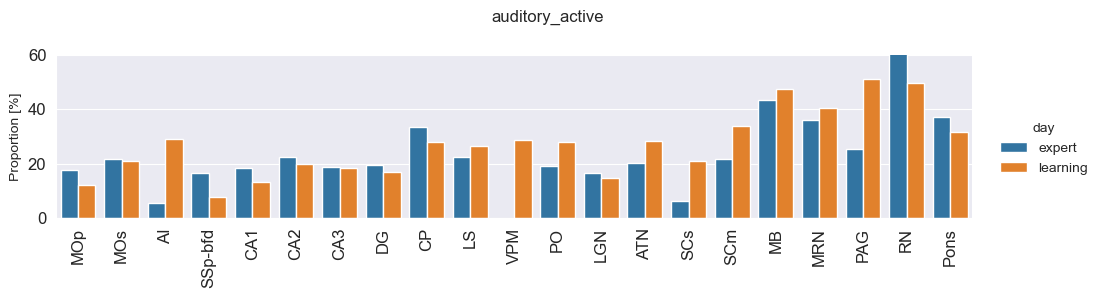

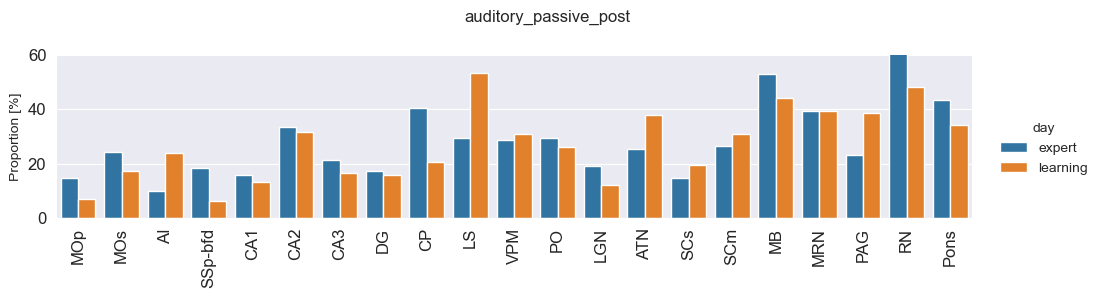

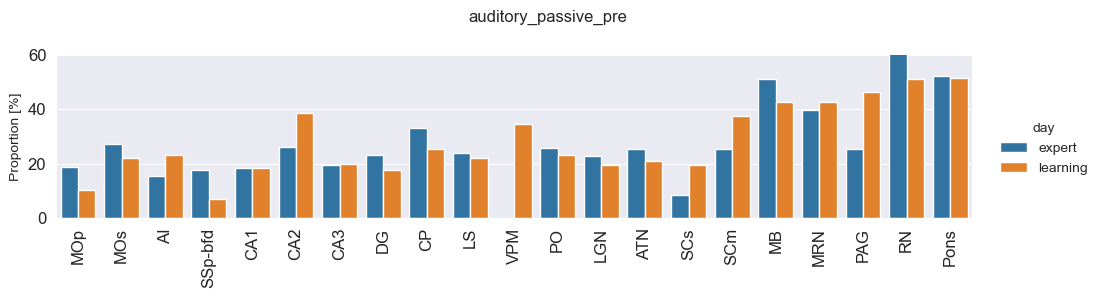

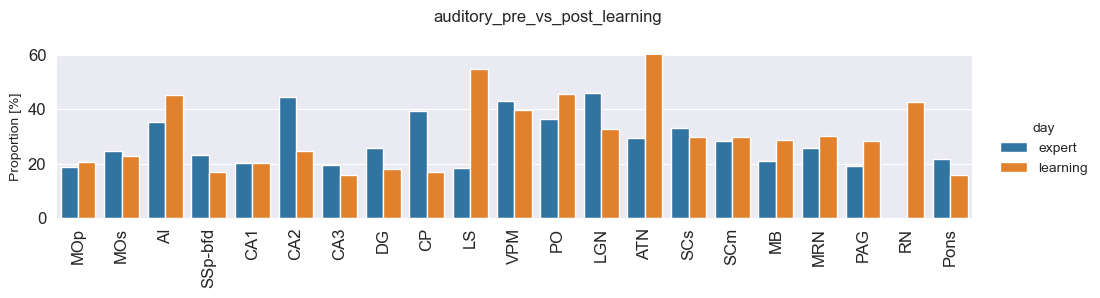

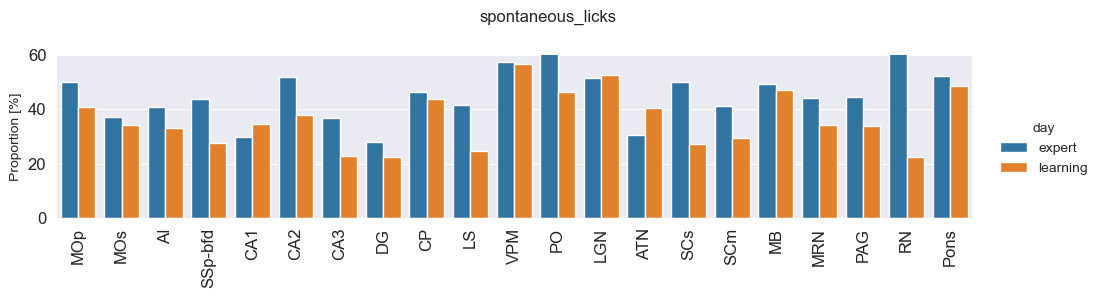

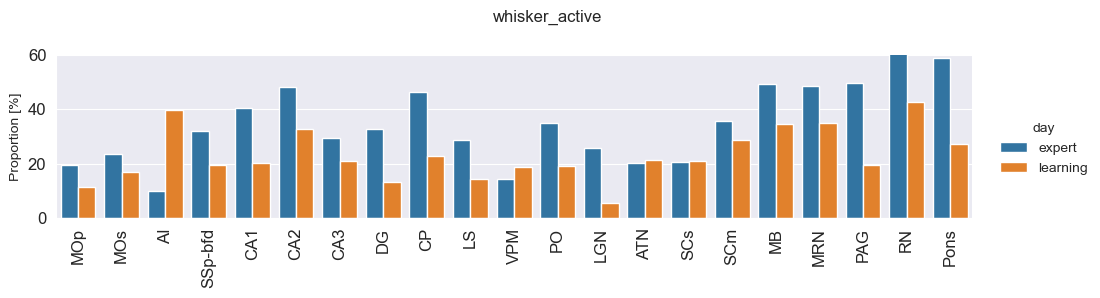

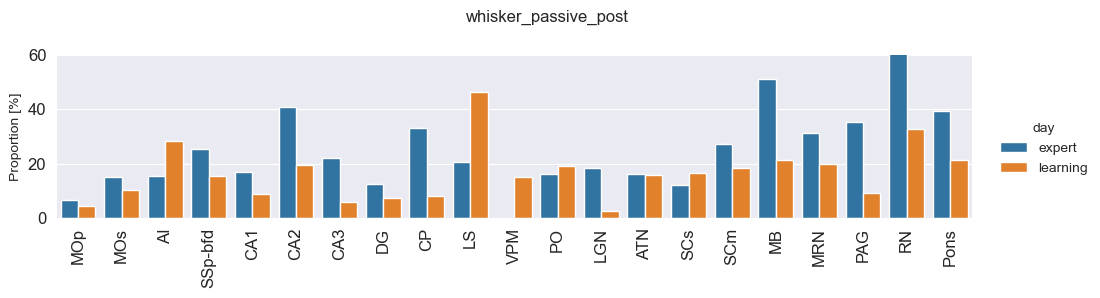

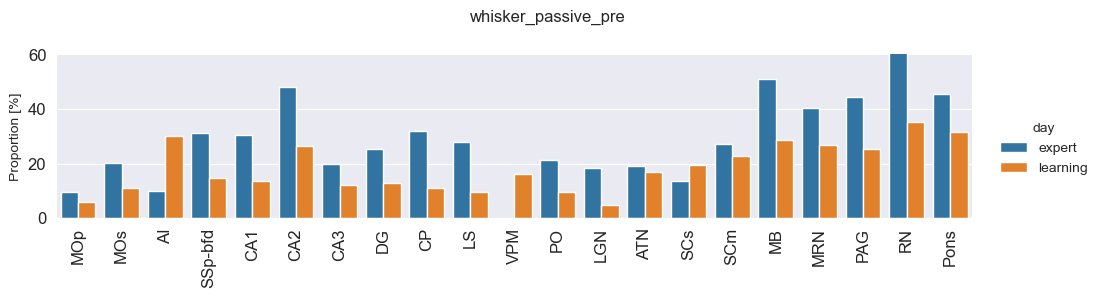

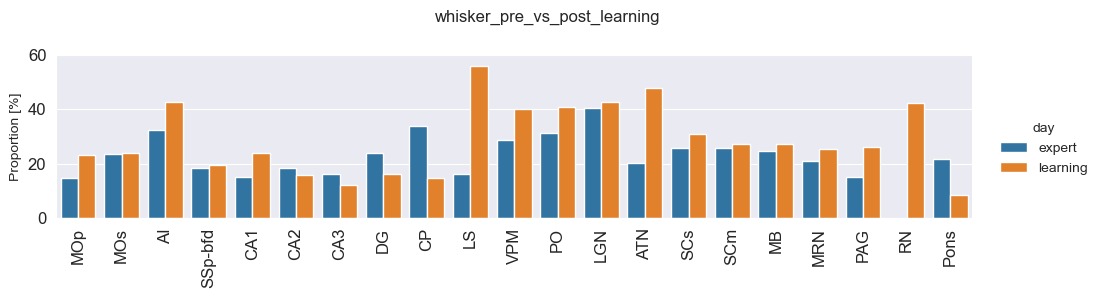

In [148]:
# Keep R+ rewarded mice only for now
roc_df_shared_areas_perc_rewarded = roc_df_shared_areas_perc[roc_df_shared_areas_perc.reward_group.eq('R+')]
roc_df_shared_areas_perc_rewarded = roc_df_shared_areas_perc_rewarded[roc_df_shared_areas_perc_rewarded.direction.eq('positive')]

for anal_type in roc_df_shared_areas_perc_rewarded['analysis_type'].unique():
    #fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
    roc_df_all_areas_type = roc_df_shared_areas_perc_rewarded[roc_df_shared_areas_perc_rewarded['analysis_type']==anal_type]

    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
        suffix = 'auditory'
    else:
        order=['positive', 'negative']
        suffix = 'positive'
    g = sns.catplot(
        data=roc_df_all_areas_type,
        kind='bar',
        x='area_acronym_custom',
        y='proportion_signed',
        order=area_order_shared,
        # palette=area_color_list,
        hue = 'day',
        #color=area_color_list,
        #row='direction',
        #hue_order=order,
        height=2.5,
        aspect=4,
        errorbar=None,
        legend=True
    )
    g.figure.suptitle(anal_type)
    g.despine(left=False)
    g.set_axis_labels('', 'Proportion [%]')
    g.set(ylim=(0, 60))
    g.tight_layout()
    g.set_xticklabels(rotation=90)
    g.tick_params(labelsize=12)

    figname = f'brainwide_roc_rplus_learning_expert_{anal_type}_{suffix}.png'
    g.savefig(os.path.join(FIGURE_PATH, figname))



C:\Users\mhamon\AppData\Local\Temp\ipykernel_11824\3961223708.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc_df_shared_areas_perc_prepost['direction_day'] = (


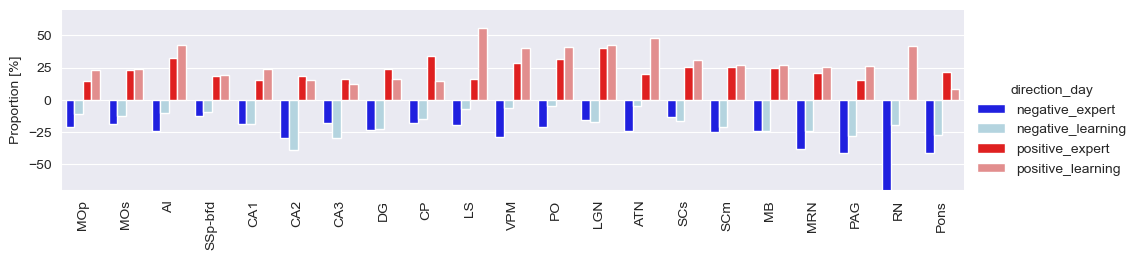

In [158]:
# Filter to exclude non-selective rows
reward_group = 'R+'
stim_type = 'whisker'

roc_df_shared_areas_perc_prepost = roc_df_shared_areas_perc[
    (roc_df_shared_areas_perc.reward_group.eq(reward_group)) &
    (roc_df_shared_areas_perc.analysis_type.eq(f'{stim_type}_pre_vs_post_learning')) &
    (roc_df_shared_areas_perc.direction != 'non-selective')  # exclude non-selective
]

# Create direction_day combo
roc_df_shared_areas_perc_prepost['direction_day'] = (
    roc_df_shared_areas_perc_prepost['direction'] + '_' + roc_df_shared_areas_perc_prepost['day']
)

# Define colors for 4 groups (positive/negative × learning/expert)
custom_palette = {
    'positive_learning': 'lightcoral',
    'positive_expert': 'red',
    'negative_learning': 'lightblue',
    'negative_expert': 'blue'
}

# Plot
g = sns.catplot(
    data=roc_df_shared_areas_perc_prepost,
    kind='bar',
    x='area_acronym_custom',
    y='proportion_signed',
    order=area_order_shared,
    hue='direction_day',
    palette=custom_palette,
    height=2.5,
    aspect=4,
    errorbar=None,
    legend=True,
    legend_out=True,
    dodge=True
)

g.despine(left=False)
g.set_axis_labels('', 'Proportion [%]')
g.set(ylim=(-70, 70))
g.set_xticklabels(rotation=90)
if reward_group == 'R+':
    reward_suffix = 'rplus'
else:
    reward_suffix = 'rminus'
# Save
figname = f'brainwide_roc_{reward_suffix}_learning_vs_expert_{stim_type}.svg'
g.savefig(os.path.join(FIGURE_PATH, figname))


C:\Users\mhamon\AppData\Local\Temp\ipykernel_11824\515436108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc_df_shared_areas_perc_prepost['direction_day'] = (


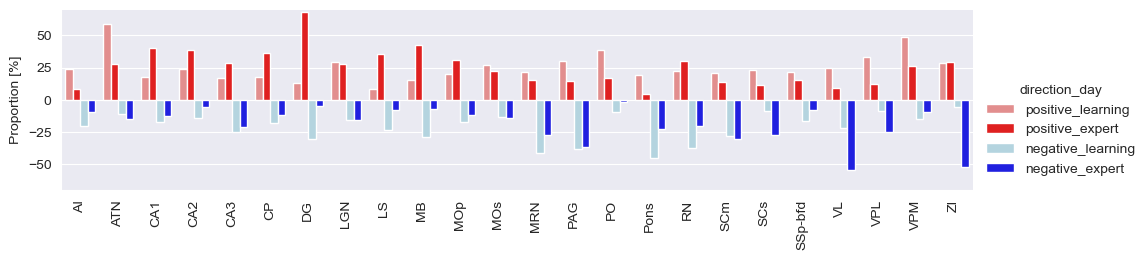

In [157]:
reward_group = 'R-'
stim_type = 'whisker'

roc_df_shared_areas_perc_prepost = roc_df_shared_areas_perc[
    (roc_df_shared_areas_perc.reward_group.eq(reward_group)) &
    (roc_df_shared_areas_perc.analysis_type.eq(f'{stim_type}_pre_vs_post_learning')) &
    (roc_df_shared_areas_perc.direction != 'non-selective')  # exclude non-selective
]

# Create direction_day combo
roc_df_shared_areas_perc_prepost['direction_day'] = (
    roc_df_shared_areas_perc_prepost['direction'] + '_' + roc_df_shared_areas_perc_prepost['day']
)
valid_areas = (
    roc_df_shared_areas_perc_prepost.groupby('area_acronym_custom')['direction_day']
    .unique()
    .apply(set)
)
required_combos = {'positive_learning', 'positive_expert', 'negative_learning', 'negative_expert'}

# Filter to keep only areas that have *all* required categories
valid_areas = valid_areas[valid_areas.apply(lambda x: required_combos.issubset(x))].index

# Filter the DataFrame
df_plot = roc_df_shared_areas_perc_prepost[
    roc_df_shared_areas_perc_prepost['area_acronym_custom'].isin(valid_areas)
]

# Plot only these
hue_order = ['positive_learning', 'positive_expert', 'negative_learning', 'negative_expert']

# Plot
g = sns.catplot(
    data=df_plot,
    kind='bar',
    x='area_acronym_custom',
    y='proportion_signed',
    hue='direction_day',
    hue_order=hue_order,
    palette=custom_palette,
    height=2.5,
    aspect=4,
    errorbar=None,
    legend=True,
    legend_out=True,
    dodge=True
)

g.despine(left=False)
g.set_axis_labels('', 'Proportion [%]')
g.set(ylim=(-70, 70))
g.set_xticklabels(rotation=90)
if reward_group == 'R+':
    reward_suffix = 'rplus'
else:
    reward_suffix = 'rminus'
# Save
figname = f'brainwide_roc_{reward_suffix}_learning_vs_expert_{stim_type}.svg'
g.savefig(os.path.join(FIGURE_PATH, figname))